In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import utils
import plotting
import os
import glob
from brainspace.gradient import GradientMaps

In [2]:
micapipe_dir = '../sourcedata/Micapipe_PNI'
hippunfold_dir = '../hippunfold/PNI_v1.3.0_super/hippunfold'
tmp_dir = 'tmp_rsfMRI'

subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015','PNC016', 'PNC018','PNC019']
ses = '01'
hemis = ['L','R']
labels = ['hipp','dentate'] 
sigma = 1 #Gaussian smoothing kernal sigma (mm)
ind = [range(419), range(419,483)]

../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC010//surf/sub-PNC010_hemi-L_space-T1w_den-0p5mm_label-dentate_*subfields*.label.gii failed
../hippunfold/PNI_v1.3.0_super/hippunfold/sub-PNC010//surf/sub-PNC010_hemi-R_space-T1w_den-0p5mm_label-dentate_*subfields*.label.gii failed


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


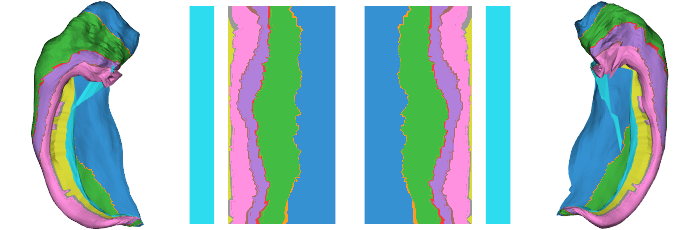

In [3]:
plotting.surfplot_sub_foldunfold(hippunfold_dir,subs[5],'',['subfields'], embed_nb=True)

In [38]:
# warp surfaces to func space then sample
!mkdir -p {tmp_dir}
shp = [419,64]

for sub in subs:
    # convert affines
    cmd1a = f'c3d_affine_tool '\
        f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-me_task-rest_bold_to-nativepro_mode-image_desc-affine_0GenericAffine.mat '\
        f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt'
    !{cmd1a}
    cmd1b = f'c3d_affine_tool '\
        f'-itk {micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_0GenericAffine.mat '\
        f'-inv '\
        f'-o {tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt'
    !{cmd1b}

    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            #apply affines
            cmd2a = f'wb_command -surface-apply-affine '\
                f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine0.txt '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii'

            !{cmd2a}
            cmd2b = f'wb_command -surface-apply-affine '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff0.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_tmp0GenericAffine1.txt '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii'
            !{cmd2b}

            # apply warp (Note this is actually the INVERSE warp)
            cmd3 = f'wb_command -surface-apply-warpfield '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_aff1.surf.gii '\
                f'{micapipe_dir}/sub-{sub}/ses-{ses}/xfm/sub-{sub}_ses-{ses}_from-nativepro_func_to-me_task-rest_bold_mode-image_desc-SyN_1Warp.nii.gz '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii'
            !{cmd3}


            # sample
            cmd4 = f'wb_command -volume-to-surface-mapping '\
                f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_deform.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                f'-enclosing'
            !{cmd4}

            # smooth
            cmd5 = f'wb_command -metric-smoothing '\
                f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-{label}_midthickness.surf.gii '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI.func.gii '\
                f'{sigma} '\
                f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii '
            !{cmd5}

            # downsample
            func = nib.load(f'{tmp_dir}/sub-{sub}_ses-{ses}_{h}_{l}_rsfMRI_smooth.func.gii')
            out_array = np.ones((len(func.darrays),shp[l]))
            for k in range(len(func.darrays)):
                data, f, v = utils.density_interp('0p5mm', '2mm',func.darrays[k].data, label,'nearest')
                out_array[k,:] = data
            data_array = nib.gifti.GiftiDataArray(data=out_array)
            image = nib.gifti.GiftiImage()
            image.add_gifti_data_array(data_array)
            nib.save(image, f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii')
                
!rm -r {tmp_dir}

In [4]:
cdata_hipp = np.ones((483,2,275,len(subs)))*np.nan
for s,sub in enumerate(subs):
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):
            cdata_hipp[ind[l],h,:,s] = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-{label}_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data.T

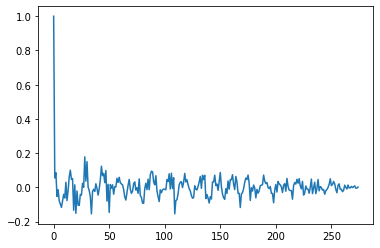

In [26]:
t = cdata_hipp[302,0,:,1]
m = np.mean(t)
var = np.var(t)
ndat = t - m
acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
acf = acf / var / len(ndat)
plt.plot(acf)

In [14]:
np.where(acf<=0)[0]

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  28,  29,  30,  32,  33,  34,  35,  37,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  62,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  84,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 111, 112, 116, 120, 121, 125, 127, 132, 134,
       135, 136, 137, 138, 139, 140, 141, 144, 145, 146, 147, 148, 149,
       158, 159, 160, 166, 167, 170, 171, 172, 176, 177, 178, 180, 181,
       182, 183, 187, 193, 194, 196, 197, 198, 199, 200, 201, 203, 204,
       205, 215, 216, 218, 219, 220, 223, 224, 227, 228, 229, 230, 234,
       235, 240, 241, 245, 246, 247, 248, 249, 250, 258, 259, 260, 262,
       263, 264, 265, 268, 269, 270, 273, 274])

In [15]:
def IntrinsicTimescale(data, TR=1, threshold=0):
    '''computes instrinsic timescale - the AUC of the autocorrelation up to the point 
    where the autocorrelation reaches threshold. 
    Input
      img: input ND data, time being the last dimension
    '''
    i = data.reshape(-1, data.shape[-1])
    out = np.zeros(i.shape[0])
    for v in range(i.shape[0]):
        m = np.mean(i[v,:])
        var = np.var(i[v,:])
        ndat = i[v,:] - m
        acf = np.correlate(ndat, ndat, 'full')[len(ndat)-1:] 
        acf = acf / var / len(ndat)
        f = np.where(acf<=threshold)[0]
        if len(f)==0:
            out[v] = np.nan
        else:
            out[v] = np.sum(acf[:f[0]])
    out = np.reshape(out,data.shape[:-1])*TR
    return out

/tmp/ipykernel_10629/18193459.py:14: RuntimeWarning: invalid value encountered in true_divide
  acf = acf / var / len(ndat)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


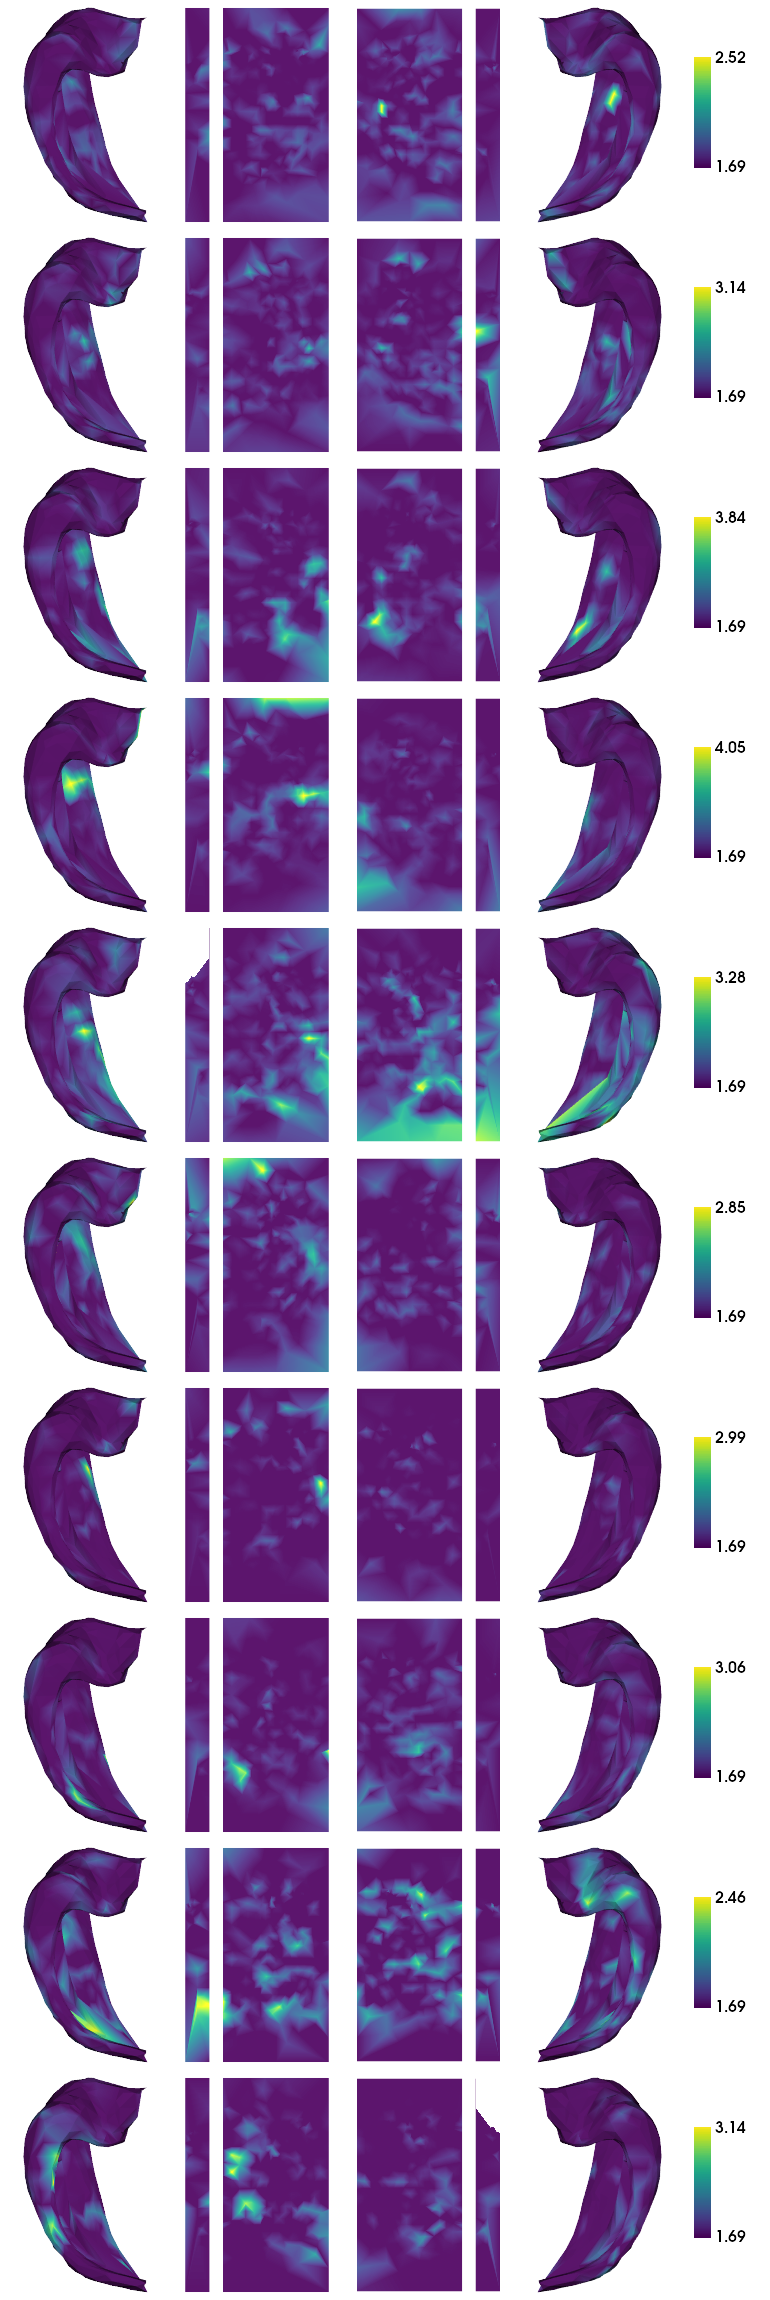

In [16]:
TR = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/volumetric/sub-{sub}_ses-{ses}_space-func_desc-me_preproc.nii.gz').header.get_zooms()[-1]
InT = np.ones((483,2,len(subs)))*np.nan
for s,sub in enumerate(subs):
    InT[:,:,s] = IntrinsicTimescale(cdata_hipp[:,:,:,s],TR, threshold=0)
plotting.surfplot_canonical_foldunfold(InT, den='2mm', share='row', color_bar='right', embed_nb=True)

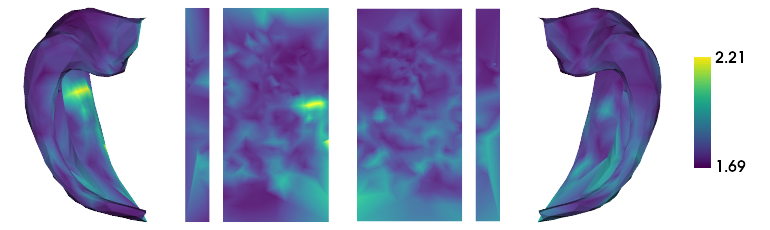

In [17]:
plotting.surfplot_canonical_foldunfold(np.nanmean(InT,axis=2), den='2mm', share='row', color_bar='right', embed_nb=True)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


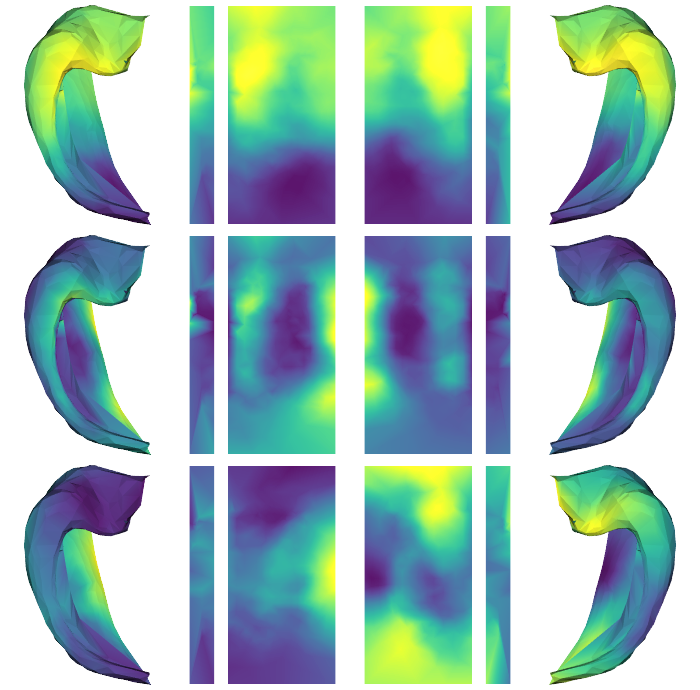

In [24]:
# load and plot reference gradients 
HCPL_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-L.npy')
HCPR_ref = np.load('/host/percy/local_raid/donna/JD_HCPref/AvgGradient_HCP-UR100_hemi-R.npy')
plotting.surfplot_canonical_foldunfold(np.stack((HCPL_ref[:,:3],HCPR_ref[:,:3]),axis=1), den='2mm', embed_nb=True)

In [18]:
neo_cdata.shape

NameError: name 'neo_cdata' is not defined

In [32]:
#run gradients for all subjects
ngrads = 10
all_grads = np.zeros((483,2,ngrads))
gm = GradientMaps(n_components=ngrads, kernel='normalized_angle', random_state=0, alignment='procrustes')
parcL = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_lh.label.gii').darrays[0].data
parcR = nib.load('/data/mica1/01_programs/micapipe/parcellations/schaefer-400_conte69_rh.label.gii').darrays[0].data
parc = np.concatenate((parcL,parcR))

clipaftertime = 200 # in TRs. This is an approximation
for sub in subs:
    neo_cdata = nib.load(f'{micapipe_dir}/sub-{sub}/ses-{ses}/func/desc-me_task-rest_bold/surf/sub-{sub}_ses-{ses}_surf-fsLR-32k_desc-timeseries_clean.shape.gii').darrays[0].data
    neo_cdata_parc = np.ones((neo_cdata.shape[0],400))
    for i in range(400):
         neo_cdata_parc[:,i] = np.nanmean(neo_cdata[:,parc==(i+1)],axis=1)
    neo_cdataL = neo_cdata_parc[:,:200]   
    neo_cdataR = neo_cdata_parc[:,200:]
    for h,hemi in enumerate(hemis):
        cdata_hipp = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-hipp_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data
        cdata_dg = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-2mm_label-dentate_rsfMRI_smooth-{sigma}mm.func.gii').darrays[0].data
        cdata_hipp = np.concatenate((cdata_hipp,cdata_dg), axis=1)
        if hemi == 'L':
            FC = np.corrcoef(cdata_hipp.T,neo_cdataL.T)
            FC[np.isnan(FC)] = 0
            gradients = gm.fit(FC[0:483,483:683], reference=HCPL_ref)
        else:            
            FC = np.corrcoef(cdata_hipp.T,neo_cdataR.T)
            FC[np.isnan(FC)] = 0
            gradients = gm.fit(FC[0:483,483:683], reference=HCPR_ref)
            
        all_grads[:,h,:] = gradients.aligned_
        # np.savetxt(os.path.join(gradient_dir, f'sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_hemi-{hemi}_gradients.txt'), all_grads[:,h,:],delimiter=',')        
        
plotting.surfplot_canonical_foldunfold(all_grads[:,:,:3], den='2mm', size=[400,200], embed_nb=True)

LinAlgError: SVD did not converge

In [ ]:
#plot subject specific gradients 
for sub in subs:
    gradientsL = np.loadtxt(f'{gradient_dir}/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_hemi-L_gradients.txt',delimiter=',')
    gradientsR = np.loadtxt(f'{gradient_dir}/sub-{sub}/ses-{ses}/sub-{sub}_ses-{ses}_hemi-R_gradients.txt',delimiter=',')
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12), subplot_kw={'projection': "3d"})
    for f in range(3):
        plotting.surfplot_canonical_foldunfold(ax[f], np.concatenate((gradientsL[:,f],gradientsR[:,f])), den='2mm')